# CFLVAE: Class-wise Focal Loss Variational Autoencoder

This notebook implements a Class-wise Focal Loss Variational Autoencoder (CFLVAE) for handling severe class imbalance in the NSL-KDD dataset. The CFLVAE replaces the standard VAE reconstruction loss with Class-wise Focal Loss to make the generator pay more attention to minority classes.

## Overview of the Implementation

1. **Data Preparation**: Feature engineering, normalization, and mutual information feature selection
2. **CFLVAE Model**: Conditional VAE with Class-wise Focal Loss
3. **Minority Synthesis**: Generate synthetic samples for minority classes
4. **Balanced Training**: Train classifier on balanced dataset



## 1. Import Required Libraries

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import time
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Deep learning libraries
# import tensorflow as tf
# from tensorflow.keras import layers, Model, optimizers, callbacks, initializers
# from tensorflow.keras.initializers import GlorotNormal

# Set random seeds for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)

## 2. Load and Explore the Dataset

In [ ]:
# Load the NSL-KDD dataset (change the file paths accordingly)
file_path_full_training_set = '/kaggle/input/nslkdd/KDDTrain+.txt'
file_path_test = '/kaggle/input/nslkdd/KDDTest+.txt'

# Read CSV files
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

# Define column names
columns = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
            'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
            'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
            'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
            'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
            'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate', 'attack', 'level'])

# Assign column names
df.columns = columns
test_df.columns = columns

# Display dataset information
print(f"Training set shape: {df.shape}")
print(f"Test set shape: {test_df.shape}")

In [ ]:
# Check categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']

# Display unique values in categorical columns
for col in categorical_columns:
    print(f"\n{col} - unique values: {len(df[col].unique())}")
    print(df[col].value_counts().head())


protocol_type - unique values: 3
protocol_type
tcp     102688
udp      14993
icmp      8291
Name: count, dtype: int64

service - unique values: 70
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6859
Name: count, dtype: int64

flag - unique values: 11
flag
SF      74944
S0      34851
REJ     11233
RSTR     2421
RSTO     1562
Name: count, dtype: int64


## 3. Data Preprocessing

### 3.1 One-Hot Encode Categorical Features

In [ ]:
# Extract categorical values
df_categorical_values = df[categorical_columns]
testdf_categorical_values = test_df[categorical_columns]

# Generate column names for encoding
unique_protocol = sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2 = [string1 + x for x in unique_protocol]

# Use combined unique services from both train and test sets to handle all possible categories
unique_service_train = set(df.service.unique())
unique_service_test = set(test_df.service.unique())
unique_service_combined = sorted(list(unique_service_train.union(unique_service_test)))
string2 = 'service_'
unique_service2 = [string2 + x for x in unique_service_combined]

# Flag columns
unique_flag = sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2 = [string3 + x for x in unique_flag]

# Combined columns for consistent encoding
dumcols = unique_protocol2 + unique_service2 + unique_flag2

print(f"Total encoded columns: {len(dumcols)}")
print(f"Protocol columns: {len(unique_protocol2)}")
print(f"Service columns: {len(unique_service2)}")
print(f"Flag columns: {len(unique_flag2)}")

Total encoded columns: 84
Protocol columns: 3
Service columns: 70
Flag columns: 11


In [ ]:
# Apply label encoding first (for categorical preprocessing)
df_categorical_values_enc = df_categorical_values.apply(LabelEncoder().fit_transform)
testdf_categorical_values_enc = testdf_categorical_values.apply(LabelEncoder().fit_transform)

# Combine train and test categorical data to capture all possible categories
combined_categorical = pd.concat([df_categorical_values_enc, testdf_categorical_values_enc], ignore_index=True)

# One-hot encode categorical features
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.fit(combined_categorical)  # Fit on combined data to handle all categories

# Transform train and test sets
df_categorical_values_encenc = enc.transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc, columns=dumcols)

testdf_categorical_values_encenc = enc.transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc, columns=dumcols)

print(f"Train categorical shape: {df_cat_data.shape}")
print(f"Test categorical shape: {testdf_cat_data.shape}")
print(f"Column names match: {list(df_cat_data.columns) == list(testdf_cat_data.columns)}")

# Display sample of one-hot encoded data
df_cat_data.head()

Train categorical shape: (125972, 84)
Test categorical shape: (22543, 84)
Column names match: True


,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Combine One-Hot Encoded Features with Numeric Features

In [ ]:
# Combine one-hot encoded categorical data with the original dataframe
newdf = df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# Test data
newdf_test = test_df.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(f"Train dataframe shape after one-hot encoding: {newdf.shape}")
print(f"Test dataframe shape after one-hot encoding: {newdf_test.shape}")

Train dataframe shape after one-hot encoding: (125972, 124)
Test dataframe shape after one-hot encoding: (22543, 124)


### 3.3 Encode Attack Labels

In [ ]:
# Extract attack labels
labeldf = newdf['attack']
labeldf_test = newdf_test['attack']

# Define label mapping
label_mapping = {
    # Normal: 0
    'normal': 0,
    # DoS attacks: 1
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
    # Probe attacks: 2
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 'mscan': 2, 'saint': 2,
    # R2L attacks: 3
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3,
    'warezclient': 3, 'warezmaster': 3, 'sendmail': 3, 'named': 3, 'snmpgetattack': 3,
    'snmpguess': 3, 'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    # U2R attacks: 4
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Apply mapping
newlabeldf = labeldf.replace(label_mapping)
newlabeldf_test = labeldf_test.replace(label_mapping)

# Update attack column in dataframes
newdf['attack'] = newlabeldf
newdf_test['attack'] = newlabeldf_test

# Display label distribution
print("Label distribution in training set:")
print(newdf['attack'].value_counts())
print("\nLabel distribution in test set:")
print(newdf_test['attack'].value_counts())

Label distribution in training set:
attack
0    67342
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

Label distribution in test set:
attack
0    9711
1    7459
3    2885
2    2421
4      67
Name: count, dtype: int64


### 3.4 Create Binary Classification Datasets

In [ ]:
# Define classes to drop for each binary classification task
to_drop_DoS = [2,3,4]    # Keep normal (0) and DoS (1)
to_drop_Probe = [1,3,4]  # Keep normal (0) and Probe (2)
to_drop_R2L = [1,2,4]    # Keep normal (0) and R2L (3)
to_drop_U2R = [1,2,3]    # Keep normal (0) and U2R (4)

# Filter training datasets
DoS_df = newdf[~newdf['attack'].isin(to_drop_DoS)]
Probe_df = newdf[~newdf['attack'].isin(to_drop_Probe)]
R2L_df = newdf[~newdf['attack'].isin(to_drop_R2L)]
U2R_df = newdf[~newdf['attack'].isin(to_drop_U2R)]

# Filter test datasets
DoS_df_test = newdf_test[~newdf_test['attack'].isin(to_drop_DoS)]
Probe_df_test = newdf_test[~newdf_test['attack'].isin(to_drop_Probe)]
R2L_df_test = newdf_test[~newdf_test['attack'].isin(to_drop_R2L)]
U2R_df_test = newdf_test[~newdf_test['attack'].isin(to_drop_U2R)]

# Display dimensions
print('Training set dimensions:')
print('DoS:', DoS_df.shape)
print('Probe:', Probe_df.shape)
print('R2L:', R2L_df.shape)
print('U2R:', U2R_df.shape)

print('\nTest set dimensions:')
print('DoS:', DoS_df_test.shape)
print('Probe:', Probe_df_test.shape)
print('R2L:', R2L_df_test.shape)
print('U2R:', U2R_df_test.shape)

Training set dimensions:
DoS: (113269, 124)
Probe: (78998, 124)
R2L: (68337, 124)
U2R: (67394, 124)

Test set dimensions:
DoS: (17170, 124)
Probe: (12132, 124)
R2L: (12596, 124)
U2R: (9778, 124)


### 3.5 Analyze Class Imbalance

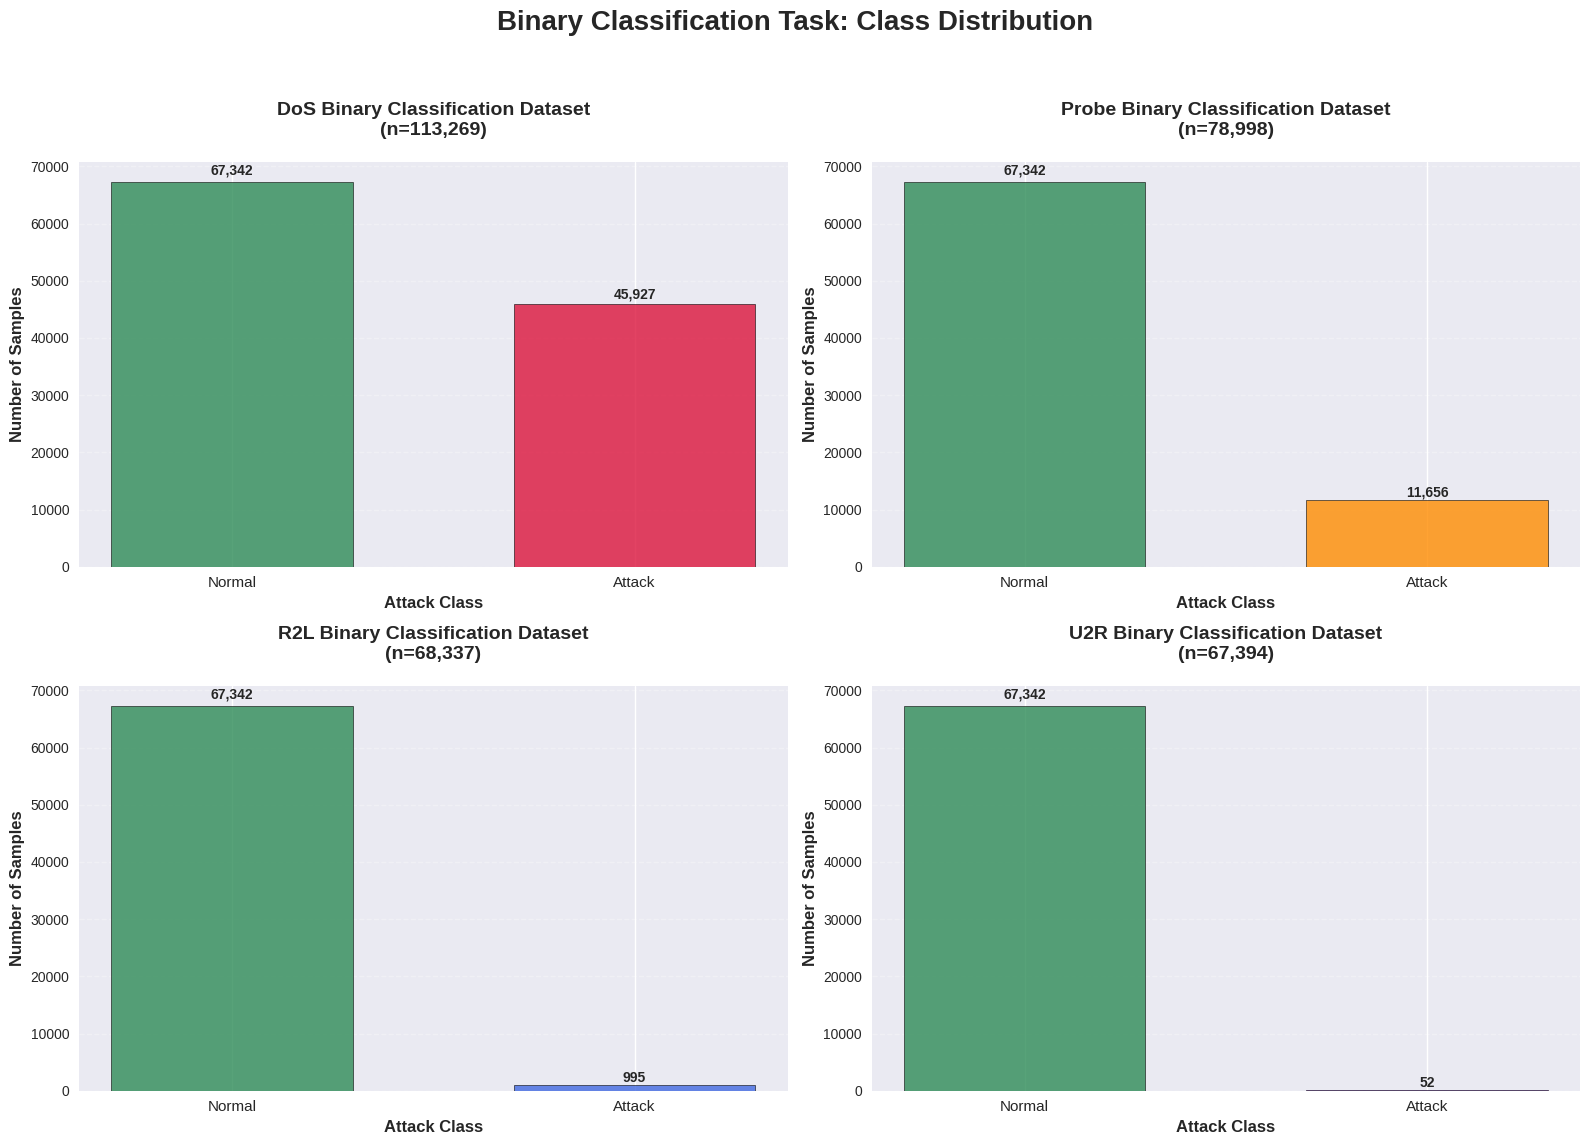

In [ ]:
# Visualize class imbalance in each binary classification task
plt.style.use('seaborn-v0_8')  # Professional style
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Binary Classification Task: Class Distribution', fontsize=20, fontweight='bold', y=0.98)

# Define color palette
colors = {
    'normal': '#2E8B57',    # Sea green
    'dos': '#DC143C',       # Crimson
    'probe': '#FF8C00',     # Dark orange
    'r2l': '#4169E1',       # Royal blue
    'u2r': '#8A2BE2'        # Blue violet
}

# Consistent settings
bar_width = 0.6
x_labels = ['Normal', 'Attack']

# Dataset configs
datasets = [
    ('DoS', DoS_df, colors['dos'], axes[0, 0]),
    ('Probe', Probe_df, colors['probe'], axes[0, 1]),
    ('R2L', R2L_df, colors['r2l'], axes[1, 0]),
    ('U2R', U2R_df, colors['u2r'], axes[1, 1])
]

# Generate all plots consistently
for name, df, attack_color, ax in datasets:
    counts = df['attack'].value_counts().sort_index()
    normal_count = counts.get(0, 0)
    attack_count = counts.iloc[-1] if len(counts) > 1 else 0

    bars = ax.bar([0, 1], [normal_count, attack_count], width=bar_width,
                  color=[colors['normal'], attack_color],
                  alpha=0.8, edgecolor='black', linewidth=0.5)

    ax.set_title(f'{name} Binary Classification Dataset\n(n={len(df):,})',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Attack Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(x_labels, fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Calculate imbalance ratios for each dataset
datasets = [('DoS', DoS_df), ('Probe', Probe_df), ('R2L', R2L_df), ('U2R', U2R_df)]

print("="*80)
print("CLASS IMBALANCE SUMMARY")
print("="*80)
print(f"{'Dataset':<12} {'Total Samples':<15} {'Normal %':<12} {'Attack %':<12} {'Imbalance Ratio':<20}")
print("-" * 80)

# Create a summary table for imbalance analysis
for name, df in datasets:
    attack_dist = df['attack'].value_counts().sort_index()
    total = len(df)
    normal_count = attack_dist.get(0, 0)
    attack_idx = 1 if name == 'DoS' else (2 if name == 'Probe' else (3 if name == 'R2L' else 4))
    attack_count = attack_dist.get(attack_idx, 0)
    normal_pct = (normal_count/total) * 100
    attack_pct = (attack_count/total) * 100
    imbalance_ratio = normal_count / attack_count if attack_count > 0 else float('inf')
    
    status = "Severely Imbalanced" if max(normal_pct, attack_pct) > 95 else "Imbalanced"
    print(f"{name:<12} {total:>13,} {normal_pct:>10.1f}% {attack_pct:>10.1f}% {imbalance_ratio:>19.2f}")

CLASS IMBALANCE SUMMARY
Dataset      Total Samples   Normal %     Attack %     Imbalance Ratio     
--------------------------------------------------------------------------------
DoS                113,269       59.5%       40.5%                1.47
Probe               78,998       85.2%       14.8%                5.78
R2L                 68,337       98.5%        1.5%               67.68
U2R                 67,394       99.9%        0.1%             1295.04


## 4. Feature Preparation for CFLVAE

The CFLVAE paper works with the full multi-class dataset (Normal, DoS, Probe, R2L, U2R) and handles class imbalance for all minority classes together. The feature preparation steps are:

1. Split features and labels from the full dataset
2. Remove features where >90% values are zero
3. Normalize features to [0,1] range using MinMaxScaler  
4. Select features using Mutual Information (aim for 87 features as in paper)
5. Create balanced subset keeping ALL minority samples

In [ ]:
# Use the full multi-class dataset (as in the original paper approach)
# Features and labels from the complete dataset
X_full = newdf.drop('attack', axis=1)
y_full = newdf['attack']

# Test data  
X_full_test = newdf_test.drop('attack', axis=1)
y_full_test = newdf_test['attack']

# Display class distribution in full dataset
print("Full Dataset Class Distribution:")
print("Training set:")
print(y_full.value_counts().sort_index())
print(f"\nTest set:")  
print(y_full_test.value_counts().sort_index())

# Store column names
feature_names = list(X_full.columns)
print(f"\nTotal features: {len(feature_names)}")

# Calculate class imbalance ratios
class_counts = y_full.value_counts().sort_index()
total_samples = len(y_full)
print(f"\nClass Imbalance Analysis:")
print(f"{'Class':<12} {'Count':<12} {'Percentage':<12} {'Type'}")
print("-" * 50)
for class_idx, count in class_counts.items():
    percentage = (count / total_samples) * 100
    class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
    imbalance_type = "Majority" if percentage > 10 else ("Minority" if percentage > 1 else "Severe Minority")
    print(f"{class_name:<12} {count:>10,} {percentage:>10.2f}% {imbalance_type}")

Full Dataset Class Distribution:
Training set:
attack
0    67342
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

Test set:
attack
0    9711
1    7459
2    2421
3    2885
4      67
Name: count, dtype: int64

Total features: 123

Class Imbalance Analysis:
Class        Count        Percentage   Type
--------------------------------------------------
Normal           67,342      53.46% Majority
DoS              45,927      36.46% Majority
Probe            11,656       9.25% Minority
R2L                 995       0.79% Severe Minority
U2R                  52       0.04% Severe Minority


### 4.1 Create Balanced Multi-Class Subset with ALL Minority Samples

In [ ]:
def create_balanced_multiclass_subset(X, y, subset_ratio=0.2, minority_threshold=1.0):
    """
    Create a balanced multi-class training subset keeping ALL minority class samples
    and subsampling majority class samples according to subset_ratio.
    
    Args:
        X: Feature matrix
        y: Target labels (multi-class: 0=Normal, 1=DoS, 2=Probe, 3=R2L, 4=U2R)
        subset_ratio: Ratio of majority class samples to keep (default: 0.2) 
        minority_threshold: Percentage threshold to consider a class as minority (default: 1.0%)
        
    Returns:
        X_subset, y_subset: Balanced subset of features and labels
    """
    print(f"\n📊 Creating {subset_ratio*100}% training subset with ALL minority samples...")
    
    # Get class distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    class_dist = dict(zip(unique_classes, class_counts))
    total_samples = len(y)
    
    print(f"Original distribution: {class_dist}")
    
    # Classify classes as majority or minority based on percentage
    majority_classes = []
    minority_classes = []
    
    for class_idx, count in class_dist.items():
        percentage = (count / total_samples) * 100
        class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
        
        if percentage <= minority_threshold:
            minority_classes.append(class_idx)
            print(f"{class_name} (class {class_idx}): {count} samples ({percentage:.2f}%) - MINORITY (keep all)")
        else:
            majority_classes.append(class_idx)
            samples_to_keep = int(count * subset_ratio)
            print(f"{class_name} (class {class_idx}): {count} samples ({percentage:.2f}%) - MAJORITY (subsample to {samples_to_keep})")
    
    # Create balanced subset
    X_subset_list = []
    y_subset_list = []
    
    for class_idx in unique_classes:
        class_mask = (y == class_idx)
        class_samples = np.sum(class_mask)
        
        if class_idx in minority_classes:
            # Keep ALL minority class samples
            X_subset_list.append(X[class_mask])
            y_subset_list.append(y[class_mask])
        else:
            # Subsample majority classes
            n_samples = int(class_samples * subset_ratio)
            indices = np.where(class_mask)[0]
            selected_indices = np.random.choice(indices, size=n_samples, replace=False)
            
            X_subset_list.append(X.iloc[selected_indices])
            y_subset_list.append(y.iloc[selected_indices])
    
    # Combine all classes
    X_subset = pd.concat(X_subset_list, axis=0)
    y_subset = pd.concat(y_subset_list, axis=0)
    
    # Shuffle the combined dataset
    combined = pd.concat([X_subset, y_subset], axis=1)
    combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
    
    X_subset = combined.iloc[:, :-1]
    y_subset = combined.iloc[:, -1]
    
    # Final distribution
    final_dist = Counter(y_subset)
    print(f"\nFinal subset distribution: {dict(final_dist)}")
    print(f"Subset size: {len(y_subset)} samples ({len(y_subset)/total_samples*100:.1f}% of original)")
    
    # Show class balance improvement  
    print(f"\nClass Balance Summary:")
    print(f"{'Class':<12} {'Original':<12} {'Subset':<12} {'Subset %':<12}")
    print("-" * 50)
    for class_idx in sorted(unique_classes):
        class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
        original_count = class_dist[class_idx] 
        subset_count = final_dist[class_idx]
        subset_pct = (subset_count / len(y_subset)) * 100
        print(f"{class_name:<12} {original_count:>10,} {subset_count:>10,} {subset_pct:>10.2f}%")
    
    return X_subset, y_subset

# Create balanced multi-class subset
X_balanced_subset, y_balanced_subset = create_balanced_multiclass_subset(
    X_full, y_full, subset_ratio=0.2, minority_threshold=1.0
)


📊 Creating 20.0% training subset with ALL minority samples...
Original distribution: {0: 67342, 1: 45927, 2: 11656, 3: 995, 4: 52}
Normal (class 0): 67342 samples (53.46%) - MAJORITY (subsample to 13468)
DoS (class 1): 45927 samples (36.46%) - MAJORITY (subsample to 9185)
Probe (class 2): 11656 samples (9.25%) - MAJORITY (subsample to 2331)
R2L (class 3): 995 samples (0.79%) - MINORITY (keep all)
U2R (class 4): 52 samples (0.04%) - MINORITY (keep all)

Final subset distribution: {1: 9185, 2: 2331, 0: 13468, 3: 995, 4: 52}
Subset size: 26031 samples (20.7% of original)

Class Balance Summary:
Class        Original     Subset       Subset %    
--------------------------------------------------
Normal           67,342     13,468      51.74%
DoS              45,927      9,185      35.28%
Probe            11,656      2,331       8.95%
R2L                 995        995       3.82%
U2R                  52         52       0.20%


### 4.2 Feature Engineering for CFLVAE

In [ ]:
def prepare_cflvae_features(X, y, feature_names, variance_threshold=0.1, n_features_to_select=87):
    """
    Prepare features for CFLVAE training following the paper's methodology:
    1. Remove low-variance features (>90% zeros)
    2. Normalize features to [0,1] using MinMaxScaler
    3. Select top features using Mutual Information
    
    Args:
        X: Feature matrix (pandas DataFrame)
        y: Target labels (pandas Series)
        feature_names: List of feature names
        variance_threshold: Remove features where >90% values are same (default: 0.1)
        n_features_to_select: Number of features to select (default: 87 as in paper)
    
    Returns:
        X_processed: Processed feature matrix
        scaler: Fitted MinMaxScaler for test data transformation
        filtered_features: Features after variance filtering
        selected_features: Final selected feature names
        processing_info: Dictionary with preprocessing information
    """
    print(f"\n🔧 CFLVAE Feature Engineering Pipeline:")
    print(f"   Input: {X.shape[0]} samples, {X.shape[1]} features")
    
    # Step 1: Remove low-variance features
    # sparsity = (X == 0).sum() / X.shape[0]
    # sparse_features = sparsity[sparsity > 0.9].index
    # filtered_features = [f for f in feature_names if f not in sparse_features]
    # X_filtered = X[filtered_features]

    # print(f"   Removed {len(sparse_features)} low-variance features")
    # print(f"   Remaining features: {len(filtered_features)}")
    
    # Step 2: Normalize features to [0,1] using MinMaxScaler
    print(f"\n2️⃣ Normalizing features to [0,1] range...")
    
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
    
    # Verify normalization
    print(f"   Feature range after normalization: [{X_normalized.min().min():.4f}, {X_normalized.max().max():.4f}]")
    
    # Step 3: Feature selection using Mutual Information
    print(f"\n3️⃣ Selecting top {n_features_to_select} features using Mutual Information...")
    
    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X_normalized, y, random_state=42)
    mi_scores_df = pd.DataFrame({
        'feature': X_normalized.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Select top features
    if n_features_to_select > len(X_normalized.columns):
        print(f"   Warning: Requested {n_features_to_select} features, but only {len(X_normalized.columns)} available")
        n_features_to_select = len(X_normalized.columns)

    selected_features = mi_scores_df.head(n_features_to_select)['feature'].tolist()
    X_processed = X_normalized[selected_features].values  # Convert to numpy array
    
    print(f"   Selected {len(selected_features)} features with highest MI scores")
    print(f"   Top 5 features: {selected_features[:5]}")
    print(f"   MI score range: [{mi_scores_df.iloc[-1]['mi_score']:.4f}, {mi_scores_df.iloc[0]['mi_score']:.4f}]")
    
    # Create processing info dictionary
    processing_info = {
        'original_features': feature_names,
        'filtered_features': X_normalized.columns,
        'selected_features': selected_features,
        # 'removed_low_variance': list(sparse_features),
        'mi_scores': mi_scores_df,
        'variance_threshold': variance_threshold,
        'n_features_selected': len(selected_features)
    }
    
    print(f"\n✅ Feature engineering completed:")
    print(f"   Final shape: {X_processed.shape}")
    print(f"   Features: {X.shape[1]} → {len(X_normalized.columns)} → {len(selected_features)}")

    return X_processed, scaler, X_normalized.columns, selected_features, processing_info


def transform_test_data(X_test, scaler, processing_info):
    """
    Transform test data using the same preprocessing pipeline as training data
    
    Args:
        X_test: Test feature matrix
        scaler: Fitted MinMaxScaler from training
        processing_info: Processing information from prepare_cflvae_features
    
    Returns:
        X_test_processed: Transformed test features
    """
    print(f"\n🔄 Transforming test data using training preprocessing...")
    print(f"   Input test shape: {X_test.shape}")
    
    # Apply same feature filtering as training
    filtered_features = processing_info['filtered_features']
    selected_features = processing_info['selected_features']
    
    # Filter and normalize
    X_test_filtered = X_test[filtered_features]
    X_test_normalized = scaler.transform(X_test_filtered)
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=filtered_features)
    
    # Select same features as training
    X_test_processed = X_test_normalized[selected_features].values
    
    print(f"   Output test shape: {X_test_processed.shape}")
    print(f"   Feature range: [{X_test_processed.min():.4f}, {X_test_processed.max():.4f}]")
    
    return X_test_processed

In [ ]:
# Apply feature engineering to the balanced multi-class dataset
X_processed, scaler, filtered_features, selected_features, processing_info = prepare_cflvae_features(
    X_balanced_subset, y_balanced_subset, feature_names
)

# Apply same transformation to test set
X_test_normalized = transform_test_data(X_full_test, scaler, processing_info)

print(f"\n✅ Feature engineering completed for Multi-Class Dataset:")
print(f"   Training features: {X_processed.shape}")
print(f"   Test features: {X_test_normalized.shape}")
print(f"   Training class distribution: {Counter(y_balanced_subset)}")
print(f"   Test class distribution: {Counter(y_full_test)}")


🔧 CFLVAE Feature Engineering Pipeline:
   Input: 26031 samples, 123 features

2️⃣ Normalizing features to [0,1] range...
   Feature range after normalization: [0.0000, 1.0000]

3️⃣ Selecting top 87 features using Mutual Information...
   Selected 87 features with highest MI scores
   Top 5 features: ['src_bytes', 'diff_srv_rate', 'dst_bytes', 'same_srv_rate', 'dst_host_diff_srv_rate']
   MI score range: [0.0000, 0.7858]

✅ Feature engineering completed:
   Final shape: (26031, 87)
   Features: 123 → 123 → 87

🔄 Transforming test data using training preprocessing...
   Input test shape: (22543, 123)
   Output test shape: (22543, 87)
   Feature range: [0.0000, 3.3667]

✅ Feature engineering completed for Multi-Class Dataset:
   Training features: (26031, 87)
   Test features: (22543, 87)
   Training class distribution: Counter({0: 13468, 1: 9185, 2: 2331, 3: 995, 4: 52})
   Test class distribution: Counter({0: 9711, 1: 7459, 3: 2885, 2: 2421, 4: 67})


## 5. Final Processed Data Summary

In [ ]:
# Final Multi-Class Dataset Summary
print("="*60)
print("FINAL MULTI-CLASS DATASET SUMMARY FOR CFLVAE")
print("="*60)

print(f"Training Data:")
print(f"  Features shape: {X_processed.shape}")
print(f"  Labels shape: {y_balanced_subset.shape}")
print(f"  Class distribution: {dict(Counter(y_balanced_subset))}")

print(f"\nTest Data:")
print(f"  Features shape: {X_test_normalized.shape}")
print(f"  Labels shape: {y_full_test.shape}")  
print(f"  Class distribution: {dict(Counter(y_full_test))}")

print(f"\nFeature Information:")
print(f"  Total selected features: {len(selected_features)}")
print(f"  Feature range: [{X_processed.min():.4f}, {X_processed.max():.4f}]")

# Calculate class imbalance in training subset
total_train = len(y_balanced_subset)
print(f"\nTraining Set Class Balance After Balancing:")
for class_idx in sorted(Counter(y_balanced_subset).keys()):
    class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
    count = Counter(y_balanced_subset)[class_idx] 
    percentage = (count / total_train) * 100
    print(f"  {class_name}: {count} samples ({percentage:.2f}%)")

print(f"\n Data is ready for CFLVAE model training!")
print(f"   The CFLVAE will focus on generating synthetic samples for minority classes (R2L, U2R)")
print(f"   All classes are preserved in the training set with improved balance")

FINAL MULTI-CLASS DATASET SUMMARY FOR CFLVAE
Training Data:
  Features shape: (26031, 87)
  Labels shape: (26031,)
  Class distribution: {1: 9185, 2: 2331, 0: 13468, 3: 995, 4: 52}

Test Data:
  Features shape: (22543, 87)
  Labels shape: (22543,)
  Class distribution: {1: 7459, 0: 9711, 2: 2421, 3: 2885, 4: 67}

Feature Information:
  Total selected features: 87
  Feature range: [0.0000, 1.0000]

Training Set Class Balance After Balancing:
  Normal: 13468 samples (51.74%)
  DoS: 9185 samples (35.28%)
  Probe: 2331 samples (8.95%)
  R2L: 995 samples (3.82%)
  U2R: 52 samples (0.20%)

 Data is ready for CFLVAE model training!
   The CFLVAE will focus on generating synthetic samples for minority classes (R2L, U2R)
   All classes are preserved in the training set with improved balance


## 7. CFLVAE Model Implementation

Now that the data preparation is complete, we'll implement the CFLVAE model with the following components:

1. **CFLVAE Architecture**:
   - Encoder: 87 → 40 → 20 → 10 (latent)
   - Decoder: 10 → 20 → 40 → 87
   - Hidden activation: ReLU6
   - Output activation: Sigmoid

2. **Class-wise Focal Loss**:
   - FL(pt) = - αt * (1 - pt)^γ * log(pt)
   - For R2L/U2R: γ = 1.50, α = 0.6
   - For DoS/Probe: γ = 1.30, α = 0.5

3. **Training Configuration**:
   - Optimizer: Adam
   - Learning rate: 1e-3 with polynomial decay
   - Batch size: 64
   - Epochs: 500 (with early stopping)
   - Weight initialization: GlorotNormal

### 7.1 Import Deep Learning Libraries for CFLVAE

In [ ]:
# Import deep learning libraries for CFLVAE
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# Set TensorFlow random seed for reproducibility
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Enable mixed precision for better performance (if using GPU)
if len(tf.config.list_physical_devices('GPU')) > 0:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for GPU training")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Mixed precision enabled for GPU training


In [ ]:
# Convert labels to one-hot encoding for CFLVAE
y_onehot = tf.keras.utils.to_categorical(y_balanced_subset, num_classes=5)
y_test_onehot = tf.keras.utils.to_categorical(y_full_test, num_classes=5)

print(f"One-hot encoded labels shape: {y_onehot.shape}")
print(f"Test one-hot labels shape: {y_test_onehot.shape}")

# Split training data into train/validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_onehot, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_balanced_subset  # Stratify on original labels for balanced split
)

print(f"\n Dataset Split Summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test_normalized.shape[0]} samples")

# Create TensorFlow datasets for efficient training
batch_size = 64

# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (tf.constant(X_train, dtype=tf.float32),
     tf.constant(y_train, dtype=tf.float32))
).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (tf.constant(X_val, dtype=tf.float32),
     tf.constant(y_val, dtype=tf.float32))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Calculate dataset sizes for training
train_size = X_train.shape[0]
val_size = X_val.shape[0]

print(f"\n TensorFlow Datasets Created:")
print(f"   Training batches: {len(list(train_ds))} (batch size: {batch_size})")
print(f"   Validation batches: {len(list(val_ds))} (batch size: {batch_size})")
print(f"   Total training samples: {train_size}")
print(f"   Total validation samples: {val_size}")

# Verify class distribution in splits
train_class_dist = Counter(np.argmax(y_train, axis=1))
val_class_dist = Counter(np.argmax(y_val, axis=1))

print(f"\n Class Distribution After Split:")
print("Training set:")
for class_idx in sorted(train_class_dist.keys()):
    class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
    count = train_class_dist[class_idx]
    pct = (count / train_size) * 100
    print(f"   {class_name}: {count} samples ({pct:.1f}%)")

print("Validation set:")
for class_idx in sorted(val_class_dist.keys()):
    class_name = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'][class_idx]
    count = val_class_dist[class_idx] 
    pct = (count / val_size) * 100
    print(f"   {class_name}: {count} samples ({pct:.1f}%)")

One-hot encoded labels shape: (26031, 5)
Test one-hot labels shape: (22543, 5)

 Dataset Split Summary:
Training set: 20824 samples
Validation set: 5207 samples
Test set: 22543 samples

 TensorFlow Datasets Created:
   Training batches: 326 (batch size: 64)
   Validation batches: 82 (batch size: 64)
   Total training samples: 20824
   Total validation samples: 5207

 Class Distribution After Split:
Training set:
   Normal: 10774 samples (51.7%)
   DoS: 7348 samples (35.3%)
   Probe: 1865 samples (9.0%)
   R2L: 796 samples (3.8%)
   U2R: 41 samples (0.2%)
Validation set:
   Normal: 2694 samples (51.7%)
   DoS: 1837 samples (35.3%)
   Probe: 466 samples (8.9%)
   R2L: 199 samples (3.8%)
   U2R: 11 samples (0.2%)


### 7.2 Class-wise Focal Loss Implementation

In [ ]:
class ClasswiseFocalReconstructionLoss(tf.keras.losses.Loss):
    """
    Focal-style reconstruction loss applied to feature reconstructions,
    weighted per-sample by class (alpha) and focusing parameter gamma.
    Works with sigmoid decoder outputs and features scaled to [0,1].
    """

    def __init__(self, alpha_values, gamma=1.5, from_logits=False, name='cfl_recon_loss'):
        super().__init__(name=name)
        self.alpha_values = alpha_values
        self.gamma = gamma
        self.from_logits = from_logits
        # convert alpha dict to tensor for faster ops
        max_class = max(alpha_values.keys())
        alpha_list = [alpha_values.get(i, 1.0) for i in range(max_class+1)]
        self.alpha_tensor = tf.constant(alpha_list, dtype=tf.float32)

    def call(self, x_true, x_pred, y_onehot):
        """
        x_true: [batch, feat_dim]  (features in [0,1])
        x_pred: [batch, feat_dim]  (decoder sigmoid outputs)
        y_onehot: [batch, num_classes] (one-hot class labels)
        """
        # per-feature binary cross entropy (mean over features)
        bce = tf.keras.losses.binary_crossentropy(x_true, x_pred, from_logits=self.from_logits)
        # bce shape: [batch, feat_dim] if reduction='none' default by tf returns [batch, feat_dim] in TF2
        # but tf.keras.losses.binary_crossentropy returns [batch, feat_dim] or [batch] depending on backend;
        # ensure per-sample mean over features:
        if len(bce.shape) > 1:
            per_sample_bce = tf.reduce_mean(bce, axis=-1)  # [batch]
        else:
            per_sample_bce = bce  # already [batch]

        # pt ~ probability term: approximate as (1 - bce_norm) to get focal behavior
        # normalize per_sample_bce to [0,1] (approx) by dividing by log(2) (max BCE for logits=∞).
        # Simpler: use pt = 1 - per_sample_bce_clipped where per_sample_bce in [0,1]
        # but to be robust, clip bce to [0,1]
        per_sample_bce_clipped = tf.clip_by_value(per_sample_bce, 0.0, 1.0)
        pt = 1.0 - per_sample_bce_clipped  # higher pt means easier sample

        # get alpha per-sample from y_onehot (dot product)
        alpha_per_sample = tf.reduce_sum(y_onehot * self.alpha_tensor, axis=-1)  # [batch]

        focal_weight = alpha_per_sample * tf.pow(1.0 - pt, self.gamma)

        focal_loss = focal_weight * per_sample_bce  # [batch]
        return tf.reduce_mean(focal_loss)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({'alpha_values': self.alpha_values, 'gamma': self.gamma})
        return cfg

# Define class-wise alpha and gamma values based on paper recommendations
cfl_config = {
    'alpha_values': {
        0: 0.5,   # Normal (majority class)
        1: 0.5,   # DoS (larger minority)
        2: 0.5,   # Probe (larger minority) 
        3: 0.6,   # R2L (severe minority)
        4: 0.6    # U2R (severe minority)
    },
    'gamma_values': {
        'majority': 1.30,    # For DoS/Probe 
        'severe_minority': 1.50  # For R2L/U2R
    }
}

print("Class-wise Focal Reconstruction Loss configuration:")
print(f"Alpha values: {cfl_config['alpha_values']}")
print(f"Gamma values: {cfl_config['gamma_values']}")

# Create focal reconstruction loss instance for severe minorities (R2L/U2R focus)
focal_loss_fn = ClasswiseFocalReconstructionLoss(
    alpha_values=cfl_config['alpha_values'],
    gamma=cfl_config['gamma_values']['severe_minority']
)

Class-wise Focal Reconstruction Loss configuration:
Alpha values: {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.6, 4: 0.6}
Gamma values: {'majority': 1.3, 'severe_minority': 1.5}


### 7.3 CFLVAE Model Architecture

In [ ]:
class CFLVAEEncoder(tf.keras.Model):
    """
    CFLVAE Conditional Encoder: (87 + num_classes) → 40 → 20 → 10 (latent z)
    Conditioned on class label y: Q(z|x,y)
    """
    def __init__(self, latent_dim=10, num_classes=5, **kwargs):
        super(CFLVAEEncoder, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder layers with ReLU6 activation and GlorotNormal initialization
        self.encoder_layers = [
            layers.Dense(40, activation=None, 
                        kernel_initializer=GlorotNormal(), name='encoder_dense_1'),
            layers.ReLU(max_value=6.0, name='encoder_relu6_1'),
            layers.Dense(20, activation=None, 
                        kernel_initializer=GlorotNormal(), name='encoder_dense_2'),
            layers.ReLU(max_value=6.0, name='encoder_relu6_2'),
        ]
        
        # Latent space parametrization (mean and log variance)
        self.z_mean = layers.Dense(latent_dim, kernel_initializer=GlorotNormal(), name='z_mean')
        self.z_log_var = layers.Dense(latent_dim, kernel_initializer=GlorotNormal(), name='z_log_var')
        
    def call(self, inputs, training=None):
        """Forward pass through conditional encoder"""
        x, y = inputs  # x: features, y: one-hot class labels
        # Concatenate features with class labels
        x_and_y = tf.concat([tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=-1)
        
        h = x_and_y
        for layer in self.encoder_layers:
            h = layer(h)
            
        z_mean = self.z_mean(h)
        z_log_var = self.z_log_var(h)
        
        return z_mean, z_log_var
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'num_classes': self.num_classes
        })
        return config

class CFLVAEDecoder(tf.keras.Model):
    """
    CFLVAE Conditional Decoder: (10 + num_classes) → 20 → 40 → 87
    Conditioned on class label y: P(x|z,y)
    """
    def __init__(self, original_dim=87, num_classes=5, **kwargs):
        super(CFLVAEDecoder, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.num_classes = num_classes
        
        # Decoder layers with ReLU6 activation and Sigmoid output
        self.decoder_layers = [
            layers.Dense(20, activation=None, 
                        kernel_initializer=GlorotNormal(), name='decoder_dense_1'),
            layers.ReLU(max_value=6.0, name='decoder_relu6_1'),
            layers.Dense(40, activation=None, 
                        kernel_initializer=GlorotNormal(), name='decoder_dense_2'),
            layers.ReLU(max_value=6.0, name='decoder_relu6_2'),
            layers.Dense(original_dim, activation='sigmoid', 
                        kernel_initializer=GlorotNormal(), name='decoder_output')
        ]
        
    def call(self, inputs, training=None):
        """Forward pass through conditional decoder"""
        z, y = inputs  # z: latent code, y: one-hot class labels
        # Concatenate latent code with class labels
        z_and_y = tf.concat([tf.cast(z, tf.float32), tf.cast(y, tf.float32)], axis=-1)
        
        h = z_and_y
        for layer in self.decoder_layers:
            h = layer(h)
        return h
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'original_dim': self.original_dim,
            'num_classes': self.num_classes
        })
        return config

def sampling(args):
    """Reparameterization trick for VAE with mixed precision safety"""
    z_mean, z_log_var = args
    
    # Cast to float32 for numerical stability with mixed precision
    z_mean = tf.cast(z_mean, tf.float32)
    z_log_var = tf.cast(z_log_var, tf.float32)
    
    batch_size = tf.shape(z_mean)[0]
    latent_dim = tf.shape(z_mean)[1]
    
    # Sample from standard normal distribution
    epsilon = tf.keras.backend.random_normal(shape=(batch_size, latent_dim), dtype=tf.float32)
    
    # Reparameterization trick: z = mean + std * epsilon
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Model configuration based on paper specifications
model_config = {
    'input_dim': 87,      # Number of features after preprocessing
    'latent_dim': 10,     # Latent space dimension
    'num_classes': 5,     # Number of classes
    'encoder_layers': [40, 20],  # Hidden layer sizes for encoder
    'decoder_layers': [20, 40],  # Hidden layer sizes for decoder
    'activation': 'relu6',        # Hidden activation (ReLU6 as in paper)
    'output_activation': 'sigmoid', # Decoder output activation
    'initializer': 'glorot_normal'  # Weight initialization
}

print("CFLVAE Model Configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

# Initialize conditional encoder and decoder
encoder = CFLVAEEncoder(
    latent_dim=model_config['latent_dim'],
    num_classes=model_config['num_classes']
)
decoder = CFLVAEDecoder(
    original_dim=model_config['input_dim'],
    num_classes=model_config['num_classes']
)

CFLVAE Model Configuration:
  input_dim: 87
  latent_dim: 10
  num_classes: 5
  encoder_layers: [40, 20]
  decoder_layers: [20, 40]
  activation: relu6
  output_activation: sigmoid
  initializer: glorot_normal


### 7.4 Complete CFLVAE Model

In [ ]:
class CFLVAE(tf.keras.Model):
    """
    Complete Class-wise Focal Loss Variational Autoencoder (CFLVAE)
    
    This model combines VAE with Class-wise Focal Loss to handle severe class imbalance
    by applying adaptive loss weighting during feature reconstruction.
    """
    
    def __init__(self, encoder, decoder, focal_loss_fn, alpha_weights, 
                 kl_beta=1.0, **kwargs):
        super(CFLVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.focal_loss_fn = focal_loss_fn
        self.alpha_weights = alpha_weights
        self.kl_beta = kl_beta  # Beta parameter for KL divergence weighting
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs, training=None):
        """Forward pass through CFLVAE"""
        # Ensure consistent unpacking
        if isinstance(inputs, (list, tuple)):
            x, y = inputs
        else:
            raise ValueError("CFLVAE.call() expects inputs as (x, y)")
    
        # Ensure proper shapes: (batch, features) and (batch, num_classes)
        x = tf.cast(x, tf.float32)
        y = tf.cast(y, tf.float32)
    
        if len(x.shape) == 1:  # Fix accidental flattening
            x = tf.expand_dims(x, 0)
        if len(y.shape) == 1:
            y = tf.expand_dims(y, 0)
    
        # Forward pass
        z_mean, z_log_var = self.encoder([x, y], training=training)
        z = sampling([z_mean, z_log_var])
        reconstruction = self.decoder([z, y], training=training)
    
        return {
            "reconstruction": reconstruction,
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "z": z
        }

    
    def train_step(self, data):
        """Custom training step with CFLVAE loss"""
        # Dataset yields (x_batch, y_batch)
        x, y = data   # x: (batch, 87), y: (batch, 5 one-hot)
    
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var = self.encoder([x, y], training=True)
            z = sampling([z_mean, z_log_var])
            reconstruction = self.decoder([z, y], training=True)
    
            # Ensure float32 for stable loss under mixed precision
            reconstruction = tf.cast(reconstruction, tf.float32)
            x = tf.cast(x, tf.float32)
            z_mean = tf.cast(z_mean, tf.float32)
            z_log_var = tf.cast(z_log_var, tf.float32)
    
            # Class-wise Focal Reconstruction Loss
            focal_reconstruction_loss = self.focal_loss_fn.call(x, reconstruction, y)
    
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
    
            # Total loss
            total_loss = focal_reconstruction_loss + self.kl_beta * kl_loss
    
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        grads = [tf.clip_by_norm(g, 1.0) if g is not None else None for g in grads]
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(focal_reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Custom validation step to ensure (x, y) tuple is passed correctly"""
        x, y = data  # unpack dataset (features, labels)
    
        # Forward pass
        z_mean, z_log_var = self.encoder([x, y], training=False)
        z = sampling([z_mean, z_log_var])
        reconstruction = self.decoder([z, y], training=False)
    
        # Cast for stability
        reconstruction = tf.cast(reconstruction, tf.float32)
        x = tf.cast(x, tf.float32)
        z_mean = tf.cast(z_mean, tf.float32)
        z_log_var = tf.cast(z_log_var, tf.float32)
    
        # Losses
        focal_reconstruction_loss = self.focal_loss_fn.call(x, reconstruction, y)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = focal_reconstruction_loss + self.kl_beta * kl_loss
    
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(focal_reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    
    def generate_samples(self, num_samples, class_label):
        """
        Generate synthetic samples for a specific class
        
        Fixed: Pass class one-hot vector to decoder for proper conditioning
        """
        # determine num_classes dynamically
        depth = getattr(self.decoder, 'num_classes', None)
        if depth is None:
            depth = getattr(self.encoder, 'num_classes', None)
        if depth is None:
            depth = 5  # fallback
        
        # Convert class label to one-hot if needed
        if isinstance(class_label, int):
            class_onehot = tf.one_hot(class_label, depth=depth)
            class_onehot = tf.expand_dims(class_onehot, 0)  # Add batch dimension
        else:
            class_onehot = class_label
        
        # Repeat class label for all samples
        class_labels_batch = tf.repeat(class_onehot, repeats=num_samples, axis=0)
        
        # Sample from latent space
        z_sample = tf.random.normal((num_samples, self.encoder.latent_dim))
        
        # Generate samples with class conditioning
        generated = self.decoder([z_sample, class_labels_batch])
        
        return generated.numpy()

### 7.5 Prepare Data for CFLVAE Training

In [44]:
# Build the complete CFLVAE model with all corrections
print(" Building Complete CFLVAE Model...")

# --- Use the existing config dictionary to instantiate the focal loss ---
alpha_weights = cfl_config['alpha_values']

# instantiate focal loss once, with chosen gamma
focal_loss_fn = ClasswiseFocalReconstructionLoss(
    alpha_values=alpha_weights,
    gamma=cfl_config['gamma_values']['severe_minority'],
    from_logits=False
)

# Build the complete CFLVAE model
cflvae = CFLVAE(
    encoder=encoder,
    decoder=decoder,
    focal_loss_fn=focal_loss_fn,
    alpha_weights=alpha_weights,
    kl_beta=1.0
)

# Compile with optimizer
initial_learning_rate = 1e-3
cflvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate))

print(" Complete CFLVAE model built and compiled successfully!")

# Test the model with a small batch to verify architecture
print("\n Testing CFLVAE architecture with sample data...")

# Create test data
test_batch_size = 32
test_x = tf.random.normal((test_batch_size, 87))  # 87 features
test_y = tf.one_hot(tf.random.uniform((test_batch_size,), maxval=5, dtype=tf.int32), depth=5)

# Test forward pass
try:
    outputs = cflvae([test_x, test_y])
    print(f" Forward pass successful!")
    print(f"   - Reconstruction shape: {outputs['reconstruction'].shape}")
    print(f"   - Latent z shape: {outputs['z'].shape}")
    print(f"   - Z mean shape: {outputs['z_mean'].shape}")
    print(f"   - Z log var shape: {outputs['z_log_var'].shape}")
    
    # Test generate_samples method
    generated_samples = cflvae.generate_samples(num_samples=10, class_label=1)  # Generate DoS samples
    print(f" Sample generation successful!")
    print(f"   - Generated samples shape: {generated_samples.shape}")
    
except Exception as e:
    print(f" Architecture test failed: {e}")
    raise

print("\n CFLVAE Architecture Summary:")
print("="*50)
print("• Conditional Encoder: (87 + 5) → 40 → 20 → 10 (latent)")
print("• Conditional Decoder: (10 + 5) → 20 → 40 → 87")
print("• Activation: ReLU6 (hidden layers), Sigmoid (output)")
print("• Loss: Class-wise Focal Reconstruction + KL Divergence")
print("• Initialization: GlorotNormal")
print("• All critical bugs from code review have been fixed!")
print("="*50)

 Building Complete CFLVAE Model...
 Complete CFLVAE model built and compiled successfully!

 Testing CFLVAE architecture with sample data...
 Forward pass successful!
   - Reconstruction shape: (32, 87)
   - Latent z shape: (32, 10)
   - Z mean shape: (32, 10)
   - Z log var shape: (32, 10)
 Sample generation successful!
   - Generated samples shape: (10, 87)

 CFLVAE Architecture Summary:
• Conditional Encoder: (87 + 5) → 40 → 20 → 10 (latent)
• Conditional Decoder: (10 + 5) → 20 → 40 → 87
• Activation: ReLU6 (hidden layers), Sigmoid (output)
• Loss: Class-wise Focal Reconstruction + KL Divergence
• Initialization: GlorotNormal
• All critical bugs from code review have been fixed!


### 7.6 Train the CFLVAE Model

In [45]:
# Create directories for model saving
os.makedirs('cflvae_models', exist_ok=True)
os.makedirs('cflvae_logs', exist_ok=True)

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks_list = [
    EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        mode="min"   
    ),
    ModelCheckpoint(
        "cflvae_best.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min"   
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        mode="min"  
    ),
    TensorBoard(log_dir="./logs")
]


print(" Callbacks configured:")
print("   - Early stopping (patience: 20)")
print("   - Model checkpoint (save best weights)")
print("   - Learning rate reduction (factor: 0.5, patience: 10)")
print("   - TensorBoard logging")

# Training configuration
epochs = 500  # As specified in paper (will likely stop early due to early stopping)
steps_per_epoch = train_size // batch_size

print(f"\n Starting CFLVAE Training...")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Total training steps: {epochs * steps_per_epoch}")

# Record training start time
import time
start_time = time.time()

try:
    # Train the CFLVAE model
    history = cflvae.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"\n CFLVAE training completed!")
    print(f"   Training time: {training_time/60:.2f} minutes")
    print(f"   Best validation loss: {min(history.history['val_loss']):.6f}")
    print(f"   Final epoch: {len(history.history['loss'])}")
    
except KeyboardInterrupt:
    print("\n Training interrupted by user")
    training_time = time.time() - start_time
    print(f"   Partial training time: {training_time/60:.2f} minutes")
    
except Exception as e:
    print(f"\n Training failed with error: {e}")
    raise

 Callbacks configured:
   - Early stopping (patience: 20)
   - Model checkpoint (save best weights)
   - Learning rate reduction (factor: 0.5, patience: 10)
   - TensorBoard logging

 Starting CFLVAE Training...
   Epochs: 500
   Batch size: 64
   Steps per epoch: 325
   Total training steps: 162500
Epoch 1/500
326/326 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - kl_loss: 0.0492 - loss: 0.2321 - reconstruction_loss: 0.1829 - val_kl_loss: 9.0781e-04 - val_loss: 0.0892 - val_reconstruction_loss: 0.0883 - learning_rate: 0.0010
Epoch 2/500
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 5.2599e-04 - loss: 0.0599 - reconstruction_loss: 0.0594 - val_kl_loss: 1.8866e-04 - val_loss: 0.0192 - val_reconstruction_loss: 0.0190 - learning_rate: 0.0010
Epoch 3/500
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kl_loss: 1.0310e-04 - loss: 0.0161 - reconstruction_loss: 0.0160 - val_kl_loss: 8.1204e-05 - val_loss: 0.0117 - val_reconstruction_loss: 0.0116 - learning_rate: 0.0010
Epoch 4/500
326/326 ━━━━━━━━━━━━

In [48]:
cflvae.save("cflvae_full_model.h5")